In [1]:
%matplotlib notebook
import firedrake
from firedrake import *
import matplotlib.pyplot as plt
import numpy as np
from constants import *
from hs_solver import *
from phi_solver import *
from model import *

# Introduction
This is a python notebook that details experiments with a 1D-subglacial hydrology model meant to represent the co-evolution of a connected channel-sheet water system based on the Glacier Drainage System model, GlaDS. This model represents the work of many previous studies including the work of Ian Hewitt, Mauro Werder, and Christian Schoof.
## Motivation
Subglacial hydrology beneath ice sheets is very difficult to observe and characterize directly, partially because the water system is very thin relative to the overlying column of kilometer thick ice. For this reason, most of what we know about subglacial hydrology at the ice sheet system scale comes from discharge observations and effective pressure measurements made beneath accessible moutain glaciers. The sampling-rate and data quality of ice sheet observing satallites now make it possible to measure large scale changes in subglacial hydrology manifest at the surface as changes in ice sheet elevation and horizontal velocity.

In Greenland, seasonal surface melt water has been observed to enhance surface velocities near the ice sheet margins by as much as $10-100$ m/yr. The importance of subglacial hydrology for understanding and predicting the evolution of ice sheets in a warming world is still widely debated and depends on the temporal/spatial resolution of the experiment and targeted goals of the study.

The simipliest kind of hydrology model requires three ingredients: 1) Description of water conservation. 2) Description of the hydraulic potential. 3) Time evolution of the drainage space (channel cross section, or sheet thickness). 

## Equations for water conservation
We assume in our model that water is incompressible and that the flux of water through any single node is equal to the flux out of that node plus local sources associated with local melting.

$\frac{dV}{dt} = Q_{in} - Q_{out} + M \Delta s$

## Hydraulic potential

The hydraulic potential beneath an ice sheet can be expressed as the sum of the pressure potential and the elevation potential:

$\phi = p_w + \rho_w g H$

where $H$ is the thickness of the water film.

## Time evolution of conduits (R-channels) and cavities (distributed sheets) 

Sheet and channel closing are both governed by the same process, creep closure, which reduces the size of cavities of thickness and channels of radius $h$ via the same equation:

$v_c(N,h) = Ah|N|^{n-1} N$

where $N$ is the effective pressure, which we can approximate as the difference between the overburden stress of the overlying ice $\phi_i$ and the  dydnamic hydropotential of the flow $\phi$. $n$ is the exponent in Glen's flow law, which we assume to be $3$.  

The mechanisms that govern the opening of channels and sheets are different. Distributed connected networks of cavities open via ice sliding over a bumpy bed:

$v_o(u_b,h) = \frac{u_b}{l_r} (h_r - h)$

where $u_b$ is the basal slip velocity (one of the mechanims by which ice dynamics feed back with the hydrology model), $l_r$ is the length scale of bed roughness, $h_r$ is the amplitude of bed roughness, and $h$ is the local thickness of the distributed cavity.

Channel opening is controlled by the exchange of potential energy in the turbulent flow with the icy side walls. The effects of Pressure melting can also lead to channel opening; however, the same pressure melting mechanism can also restrict channel formation, especially on retrograde bed slopes. The expressions for the channel opening (and occasional closing due to pressure melting) are:





# Initializing the model
First we need to call the mesh objects created for our shmip experiments and real glacier geometries. For more information on these experiments see the inputs directory and the mesh generation notebook.

In [2]:
########### Domain Geometry SHMIP A ############
proj_dir = '/Volumes/hoffmaao/data/rd06/projects/thwiates_modeling/1Dhydrology/'

Lx = 100e3
nx =1000
b0=0.
W = 3000.
flux_condition = 0.0
mesh = firedrake.IntervalMesh(nx,Lx)
degree = 1
V_cg = firedrake.FunctionSpace(mesh,"CG",degree)

In [3]:
H=firedrake.Function(V_cg)
B=firedrake.Function(V_cg)
x = firedrake.SpatialCoordinate(mesh)
H=firedrake.interpolate(6*(firedrake.sqrt(firedrake.sqrt(x[0])+5000.)-firedrake.sqrt(firedrake.sqrt(5000.)))+firedrake.Constant(1.) ,V_cg)
B=firedrake.interpolate(firedrake.Constant(b0),V_cg)
width = firedrake.interpolate(firedrake.Constant(W),V_cg)
ub = firedrake.Function(V_cg)

#slip velocity and melt rate defined in the SHMIP experiment.
ub=firedrake.interpolate(firedrake.Constant(1e-6),V_cg)
m = firedrake.interpolate((firedrake.Constant(7.93e-11)),V_cg)

H_out = firedrake.File(proj_dir + "inputs/H.pvd")
B_out = firedrake.File(proj_dir + "inputs/B.pvd")

ub_out = firedrake.File(proj_dir + "inputs/ub.pvd")
m_out = firedrake.File(proj_dir + "inputs/m.pvd")

H_out.write(H)
B_out.write(B)
ub_out.write(ub)
m_out.write(m)

The variable m represents the combined fluxes associated with melt and any flux from the lakes.

In [4]:
firedrake.plot(m)

<IPython.core.display.Javascript object>

In [5]:
########### Model Initializtion ############


h_init = firedrake.Function(V_cg)
#h_init = firedrake.interpolate(.01/(1.0+x[0]),V_cg)
h_init = firedrake.interpolate(Constant(1e-9),V_cg)

S_init = firedrake.Function(V_cg)
#S_init = firedrake.interpolate((.01*((50e3+1)-x[0])/50e3),V_cg)

phi_init = firedrake.Function(V_cg)

phi_init=pcs['g']*H*pcs['rho_ice'];

In [6]:
# Load potential at 0 pressure
phi_m = firedrake.Function(V_cg)
phi_m = B*pcs['g']*pcs['rho_water']
# Ice overburden pressure
p_i = firedrake.Function(V_cg)
p_i = H*pcs['g']*pcs['rho_ice']+firedrake.Constant(.001)
# Enforce 0 pressure bc at margin
bc = firedrake.DirichletBC(V_cg, phi_m+p_i,1)

# Initialize hydropotential
phi_init=firedrake.Function(V_cg)
phi_init=phi_m+p_i
#pcs['k'] = firedrake.Constant(5e-4)
#pcs['k_c'] = firedrake.Constant(0.05)


In [7]:
model_inputs = {}
model_inputs['phi_m'] = phi_m
model_inputs['p_i'] = p_i
model_inputs['phi_0'] = phi_m + p_i
model_inputs['mesh'] = mesh
model_inputs['H'] = H
model_inputs['B'] = B
model_inputs['u_b'] = ub
model_inputs['m'] = m
model_inputs['h_init'] = h_init
model_inputs['S_init'] = S_init
model_inputs['phi_init'] = phi_init
model_inputs['d_bcs'] = [bc]
model_inputs['width'] = width
model_inputs['out_dir'] = proj_dir + "outputs/"
model_inputs['constants'] = pcs

In [8]:
# Create the Glads model
model = Glads1DModel(model_inputs)
# End time
T = 5.0*pcs['spd']
# Time step
dt = 60.0

In [9]:
plot(model.h)
plot(model.S)
plot(model.H)
plot(model.B)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
############# Run simulation ################

while model.t < T:
    model.step(dt)
    print(model.t)

60.0
120.0
180.0
240.0
300.0
360.0
420.0
480.0
540.0
600.0
660.0
720.0
780.0
840.0
900.0
960.0
1020.0
1080.0
1140.0
1200.0
1260.0
1320.0
1380.0
1440.0
1500.0


ConvergenceError: Nonlinear solve failed to converge after 0 nonlinear iterations.
Reason:
   DIVERGED_LINE_SEARCH

<IPython.core.display.Javascript object>


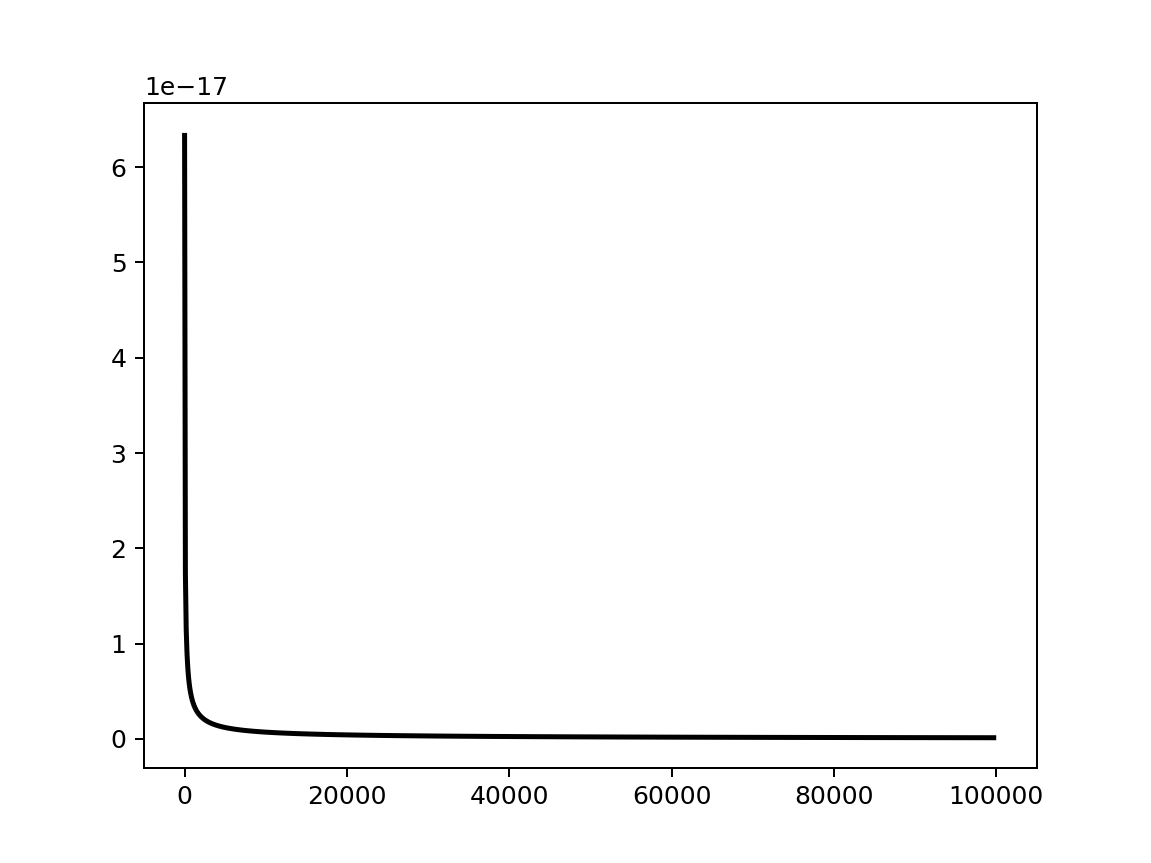

<IPython.core.display.Javascript object>


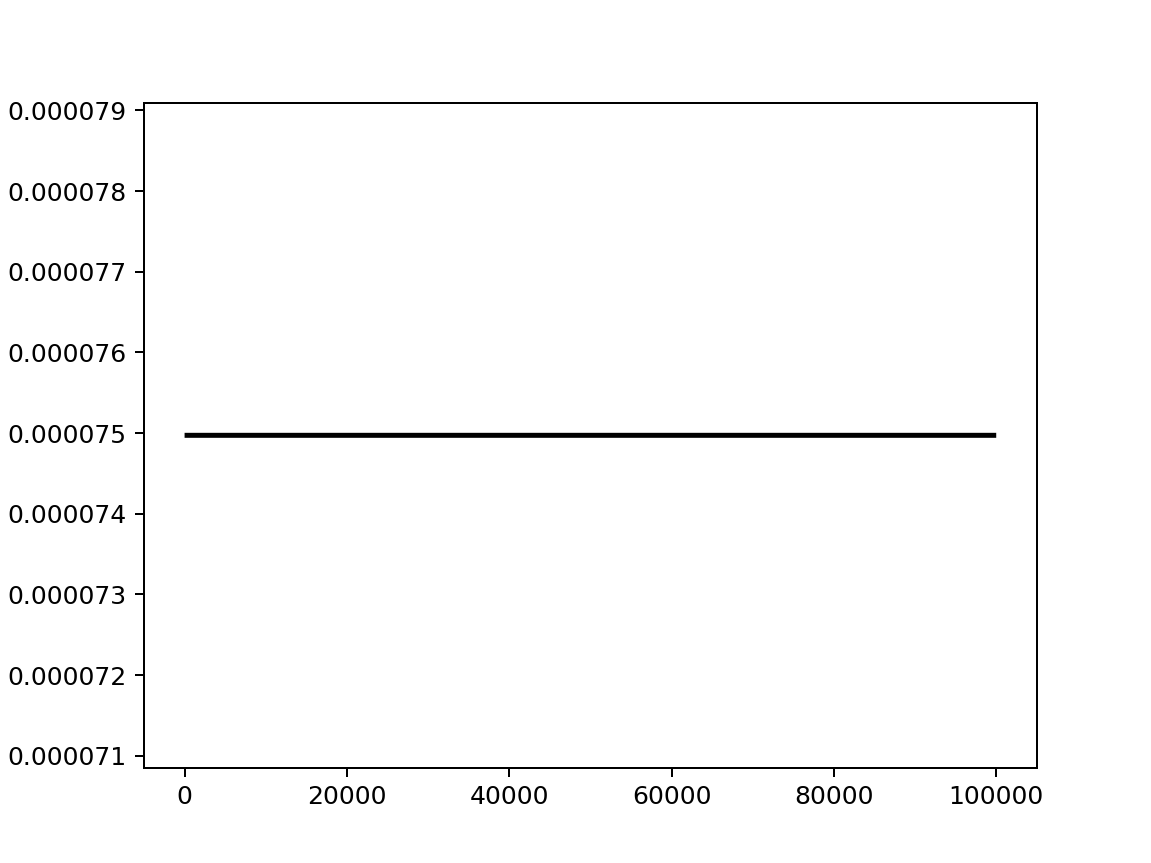

<IPython.core.display.Javascript object>


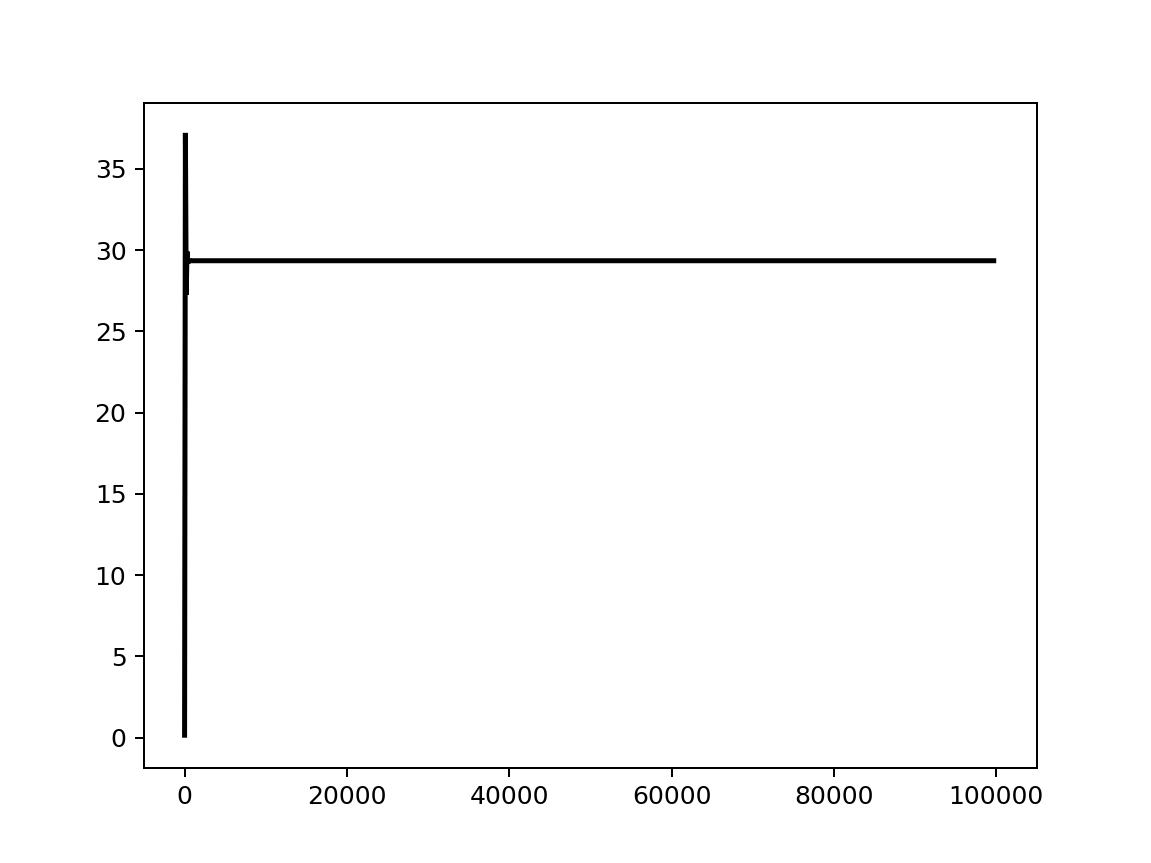

<IPython.core.display.Javascript object>


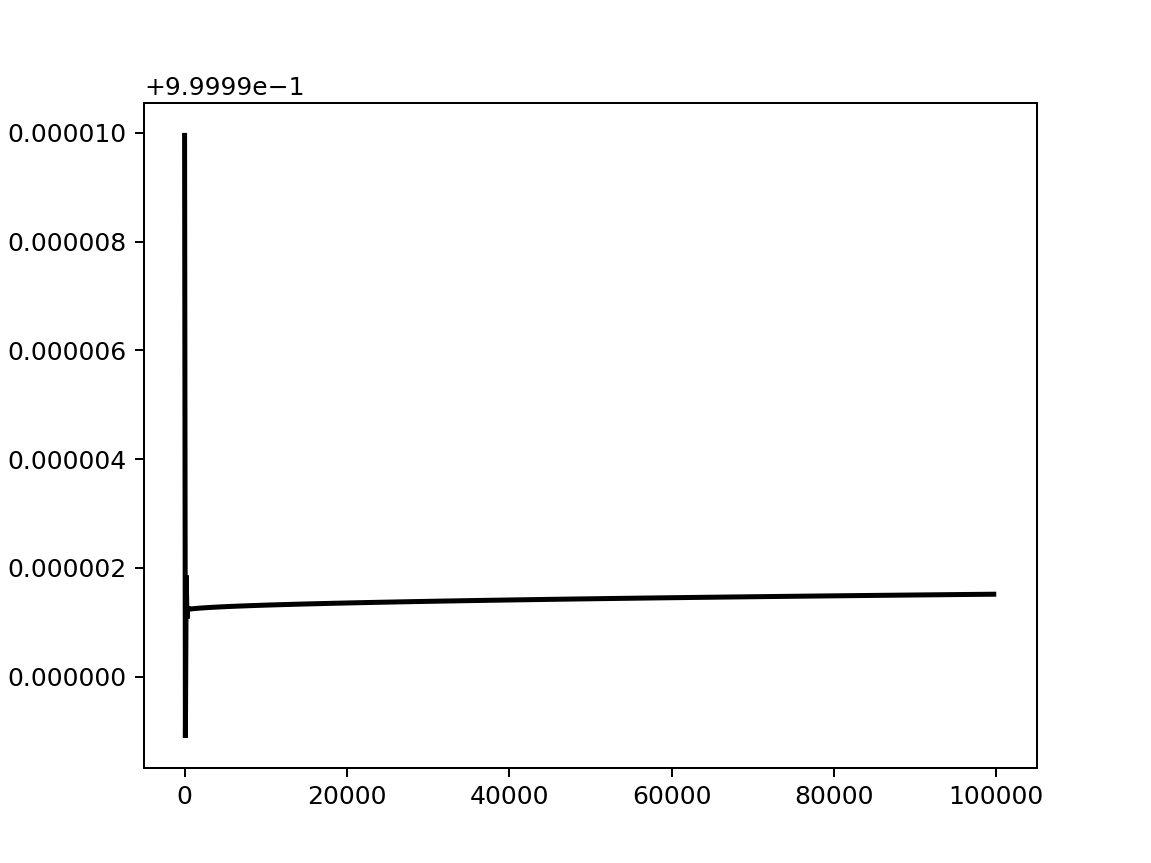

In [11]:
plot(model.S)
plot(model.h)
plot(model.N)
plot(model.pfo)

In [ ]:
phi_solver_1=PhiSolver(model)
# Get melt rate
m = model.m
# Sheet height
h = model.h
# Channel areas
S = model.S
# This function stores the value of S**alpha.
S_alpha = model.S_alpha
# Basal sliding speed
u_b = model.u_b
# Potential
phi = model.phi
# Potential at previous time step
phi_prev = model.phi_prev
# Potential at overburden pressure
phi_0 = model.phi_0
# Density of ice
rho_i = model.pcs['rho_ice']
# Density of water
rho_w = model.pcs['rho_water']
# Rate factor
A = model.pcs['A']
# Sheet conductivity
k = model.pcs['k']
# Channel conductivity
k_c = model.pcs['k_c']
# Bump height
h_r = model.pcs['h_r']
# Distance between bumps
l_r = model.pcs['l_r']
# Sheet width under channel
l_c = model.pcs['l_c']
# Latent heat
L = model.pcs['L']
# Width of distributed drainage
#W = model.pcs['W']
# Void storage ratio
e_v = model.pcs['e_v']
# Gravitational acceleration
g = model.pcs['g']
# Exponents
alpha = model.pcs['alpha']
delta = model.pcs['delta']
# pcs in front of storage term
c1 = e_v / (rho_w * g)
# Regularization parameter
phi_reg = 1e-15
  
### set up sheet model
# Expression for effective pressure in terms of potential
N = phi_0 - phi
# Derivative of phi
dphi_tmp = phi.dx(0)
#dphi_ds = firedrake.interpolate(dphi_tmp,V_cg)
# Flux vector
#q = -firedrake.Constant(k) * h**alpha * abs(dphi_ds + phi_reg)**(delta) * dphi_ds
q = -firedrake.Constant(k) * h**alpha * abs(phi.dx(0) + phi_reg)**(delta) * phi.dx(0)
# Opening term 
w = firedrake.conditional(firedrake.gt(h_r - h, 0.0), u_b * (h_r - h) / l_r, 0.0)
# Closing term
v = firedrake.Constant(A) * h * N**3



### Set up the channel model 

# Discharge through channels
Q = -firedrake.Constant(k_c) * S_alpha * abs(phi.dx(0) + firedrake.Constant(phi_reg))**delta * phi.dx(0)
# Approximate discharge of sheet in direction of channel
q_c = -firedrake.Constant(k) * h**alpha * abs(phi.dx(0) + firedrake.Constant(phi_reg))**delta * phi.dx(0)
# Energy dissipation 
Xi = abs(Q * phi.dx(0)) + abs(firedrake.Constant(l_c) * q_c * phi.dx(0))
# Channel creep closure rate
v_c = firedrake.Constant(A) * S * N**3
# Another channel source term
w_c = (Xi / firedrake.Constant(L)) * firedrake.Constant((1. / rho_i) - (1. / rho_w))

### Set up the PDE for the potential ###

# Measure for integrals over mesh boundaries
#ds = firedrake.Measure("ds")[model.boundaries]
#dx = firedrake.Measure('dx',domain=model.mesh)
theta = firedrake.TestFunction(model.V_cg)

# Constant in front of storage term
C1 = firedrake.Constant(c1)
# Storage term
F_s = C1 * (phi - phi_prev) * theta * firedrake.dx
# Sheet contribution to PDE
F_s += dt * (-theta.dx(0) * q + (w - v - m) * theta) * firedrake.dx 

# Add any non-zero Neumann boundary conditions
for (m, c) in model.n_bcs: 
    F_s += dt * firedrake.Constant(c) * theta * m

# Channel contribution to PDE
F_c = dt * ((-theta.dx(0)) * Q + (w_c - v_c) * theta('+') )* firedrake.dx
# Variational form
F = F_s + F_c

# Get the Jacobian
dphi = firedrake.TrialFunction(model.V_cg)
J = firedrake.derivative(F_s, phi, dphi) 


### Assign local variables

phi_solver_1.F = F_s
phi_solver_1.J = J
phi_solver_1.model = model
phi_solver_1.dt = 460
phi_solver_1.model.d_bcs

In [ ]:
solve(phi_solver_1.F == 0, phi_solver_1.model.phi, phi_solver_1.model.d_bcs, J = phi_solver_1.J,solver_parameters={
                         'snes_type': 'newtonls',
                         'snes_rtol': 5e-11,
                         'snes_atol': 5e-10,
                         'pc_type': 'lu',
                         'snes_max_it': 50,
                         'mat_type': 'aij'})




In [ ]:
plot(model.phi)
plot(model.S)
plot(model.h)
plot(model.N)
plot(model.pfo)